# This notebook uses basebase data from MLB StatCast to build a logical regression GLM 

In [1]:
import pandas as pd

RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    !git clone https://github.com/GregGlickert/GLMs.git
    data = pd.read_csv("GLMs/HomeRunData.csv")
else:
    data = pd.read_csv("HomeRunData.csv")

data.loc[data['home_run'] == 0 ,'home_run'] = 'no homerun'
data.loc[data['home_run'] == 1 ,'home_run'] = 'homerun!'
data.head()


,pitch_speed,pitch_spin,pitch_horizontal_movement,pitch_vertical_movement,plate_x,plate_z,pitcher_hand,launch_angle,launch_speed,stand,home_run
0,85.6,1984.0,-1.57,1.08,0.14,2.08,R,22.0,85.5,L,no homerun
1,85.4,2450.0,0.68,0.71,0.89,2.17,R,7.0,63.7,R,no homerun
2,88.8,1994.0,-1.15,1.46,-0.29,2.73,R,-45.0,71.0,R,no homerun
3,89.2,2195.0,-1.22,1.07,-0.61,1.92,R,-6.0,97.9,R,no homerun
4,96.0,2324.0,-1.46,0.61,-0.53,1.86,R,21.0,79.2,L,no homerun


## We can make some plots to see how some varibles are related to a homerun. We can see pretty much every homerun has a launch_angle of 20-40 and a launch_speed of 90-110. 

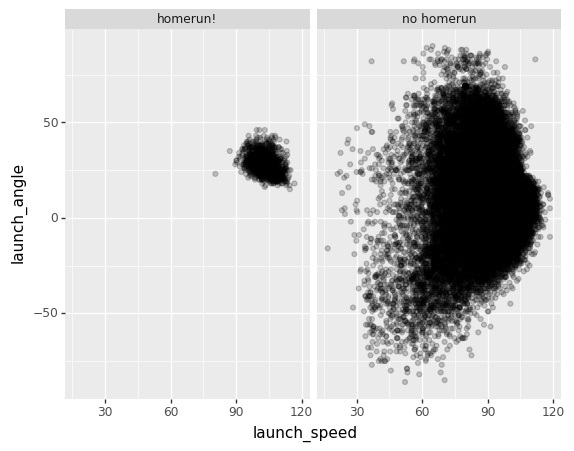

<ggplot: (8777836709521)>

In [2]:
from plotnine import ggplot, aes, geom_point, facet_grid, position_jitter

ggplot(data) + aes(x = "launch_speed", y = "launch_angle") + geom_point(alpha = 0.2, position = position_jitter()) + facet_grid("~home_run")



## Let us start by making a GLM with a all of our varibles and look at how the model does

In [3]:
import statsmodels.api as sm
from patsy import dmatrices

y, X = dmatrices('home_run ~ launch_speed + launch_angle + pitch_speed + pitch_spin + pitch_horizontal_movement + pitch_vertical_movement + plate_x + plate_z + pitcher_hand', data=data, return_type='dataframe')
model = sm.GLM(endog=y, exog=X, family = sm.families.Binomial()).fit()

print(model.summary())


                               Generalized Linear Model Regression Results                                
Dep. Variable:     ['home_run[homerun!]', 'home_run[no homerun]']   No. Observations:                29596
Model:                                                        GLM   Df Residuals:                    29586
Model Family:                                            Binomial   Df Model:                            9
Link Function:                                              Logit   Scale:                          1.0000
Method:                                                      IRLS   Log-Likelihood:                -3055.5
Date:                                            Mon, 13 Feb 2023   Deviance:                       6111.1
Time:                                                    13:13:54   Pearson chi2:                 2.05e+04
No. Iterations:                                                 9   Pseudo R-squ. (CS):             0.1414
Covariance Type:                     

## A good metric for how well a model did is called chi^2 and for our model and a good value for this is below 0.05. For our model it is so low it is rounded down to zero by the computer so that is good! Another metric is called AIC and we can use this value to compare how differnt models do.

In [4]:
from scipy import stats

deviance = model.null_deviance - model.deviance

print("Our Chi sqared for this model is {}".format(stats.chi2.pdf(deviance , 8)))

print("Our AIC value is {}".format(model.aic))



Our Chi sqared for this model is 0.0
Our AIC value is 6131.068505468025


## By looking back at our model we can see that some features are not as important as other in our model. We can see this effect off dropping features by running our models with different features and comparing AIC values. 

In [5]:
y, X = dmatrices('home_run ~ pitch_spin + pitch_horizontal_movement + pitch_vertical_movement + plate_x + plate_z + pitcher_hand', data=data, return_type='dataframe')
bad_model = sm.GLM(endog=y, exog=X, family = sm.families.Binomial()).fit()

y, X = dmatrices('home_run ~ launch_speed + launch_angle + pitch_speed', data=data, return_type='dataframe')
better_model = sm.GLM(endog=y, exog=X, family = sm.families.Binomial()).fit()

print("AIC for bad features is {}".format(bad_model.aic))
print("AIC for good features is {}".format(better_model.aic))



AIC for bad features is 10587.073945002048
AIC for good features is 6122.636436048208


## The lower the AIC the better so our model with only the "good features" is preforming better than our other model. We can also see that our AIC value is much much higher with our "bad features". The model with good features was just a model with a low P value and the bad features was all the other models

## Now using the probability of 0.5 (from sigmoid function) lets see how well we well our model did

In [22]:
pred_prob = better_model.predict()
pred = []
for i in range(len(pred_prob)):
    if pred_prob[i] > 0.5:
        pred.append(1)
    else:
        pred.append(0)
num_correct = 0
num_wrong = 0
for i in range(len(pred)):
    if pred[i] == 1 and data.home_run[i] == 'homerun!':
        num_correct = num_correct + 1
    if pred[i] == 0 and data.home_run[i] == 'no homerun':
        num_correct = num_correct + 1
    if pred[i] == 1 and data.home_run[i] == 'no homerun':
        num_wrong = num_wrong + 1
    if pred[i] == 0 and data.home_run[i] == 'homerun!':
        num_wrong = num_wrong + 1

print("our model got {:2f}% correct".format(num_correct/(num_correct+num_wrong)*100))
    

our model got 95.904852% correct


# our model got 95.9% of predicting if a homerun would happen or not so thats good!